# start

## load the dependencies


In [44]:


#* libraries we will need.
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [46]:
# Limit CPU usage for TensorFlow
import tensorflow as tf
import multiprocessing

# Get number of available CPU cores
num_cpu = multiprocessing.cpu_count()
num_cpu_to_use = int(num_cpu * 0.7)  # Use 70% of available CPUs

# Configure TensorFlow to use specific number of threads
tf.config.threading.set_intra_op_parallelism_threads(num_cpu_to_use)
tf.config.threading.set_inter_op_parallelism_threads(num_cpu_to_use)

print(f"Total CPUs: {num_cpu}, Using: {num_cpu_to_use} (70%)")

# For memory limitation
import resource
import psutil

# Get total system memory
try:
    total_memory = psutil.virtual_memory().total
    memory_limit = int(total_memory * 0.7)  # 70% of memory
    
    # Set soft limit
    resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))
    print(f"System memory limited to {memory_limit/(1024**3):.2f} GB (70%)")
except Exception as e:
    print(f"Could not set memory limit: {e}")
    
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # For GPU devices, we can use memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s), memory growth enabled")
    except Exception as e:
        print(f"Error configuring GPUs: {e}")

Total CPUs: 8, Using: 5 (70%)
Could not set memory limit: current limit exceeds maximum limit


## loading the data

In [47]:
# load the data its in the Train directory its not a csv its just wav files

# get every file from the Train directory
train_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'
train_files = os.listdir(train_dir)

# make csv file out of the files 
train_df = pd.DataFrame(train_files, columns=['file'])

# create a column with the file path 
train_df['file_path'] = train_df['file'].apply(lambda x: os.path.join(train_dir, x))

# create a column with the file name without the .wav extension
train_df['file_name'] = train_df['file'].str.replace('.wav', '')

# create a column with the accent from the first numer of the file name
train_df['accent'] = train_df['file_name'].str[0]

# create a column with male or female from the second incex of the file name
train_df['gender'] = train_df['file_name'].str[1]

train_df

,file,file_path,file_name,accent,gender
0,2m_9039.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_9039,2,m
1,4f_1887.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_1887,4,f
2,4f_9571.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_9571,4,f
3,1m_3736.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3736,1,m
4,1m_3078.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3078,1,m
...,...,...,...,...,...
3161,3f_3974.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3f_3974,3,f
3162,3m_7330.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3m_7330,3,m
3163,5f_2072.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_2072,5,f
3164,2m_6475.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_6475,2,m


In [48]:
test_dir = '/Users/kaispeidel/Downloads/DeepLearning/Test'
test_files = os.listdir(test_dir)

test_df = pd.DataFrame(test_files, columns=['file'])
test_df['file_path'] = test_df['file'].apply(lambda x: os.path.join(test_dir, x))
test_df['file_name'] = test_df['file'].str.replace('.wav', '')

# create an empty column for the accent and gender
test_df['accent'] = ''
test_df['gender'] = ''
 
test_df

,file,file_path,file_name,accent,gender
0,9430.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,9430,,
1,4458.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4458,,
2,1534.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,1534,,
3,8510.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8510,,
4,7192.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,7192,,
...,...,...,...,...,...
546,8910.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8910,,
547,8904.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8904,,
548,4680.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4680,,
549,4858.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4858,,


## first try

from: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5/


# approach a) 

use the spectrogram and analyse it as a 2D input with the CNN

In [49]:
import librosa
import torch

def load_and_PreProcess(path):
    try: 
        audio, sr = librosa.load(path)
        audio_tensor = torch.tensor(audio)
        return audio_tensor, sr, audio
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None, None

In [50]:
# apply the function to all files in the train  dataframes first crete a new copy

nummer = len(train_df)

df = train_df[:nummer].copy()


In [51]:
lengths = []

for file in df['file_path']:
    audio, sr = librosa.load(file)
    lengths.append(len(audio))

max_length = max(lengths)
print(f"Max length: {max_length}")

Max length: 286003


## try agin

In [52]:
classes = df['accent'].unique()
print(f"Classes: {classes}")

Classes: ['2' '4' '1' '3' '5']


In [53]:
class_dict = {i:x for x,i in enumerate(classes)}
print(f"Class dict: {class_dict}")

Class dict: {'2': 0, '4': 1, '1': 2, '3': 3, '5': 4}


In [54]:
df['target'] = df['accent'].map(class_dict)
print("df shape: ", df.shape)

df shape:  (3166, 6)


In [55]:
data_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'  #* folder with all our training .wav files
n_mfcc = 14       #* number of mfcc features to extract - can go higher for more detail e.g. 40
max_length = 1000    #* standardized length for all audio samples - need this for the neural net
sr = 16000  #* sample rate we'll use for processing, standard for speech audio

In [56]:
def custom_pad_mfcc(mfcc, fixed_length):
    n_mfcc, time_steps = mfcc.shape
    padded = np.zeros((n_mfcc, fixed_length))  #*  zero-filled array

    #* copy the MFCC values into the padded array
    length_to_copy = min(time_steps, fixed_length)
    padded[:, :length_to_copy] = mfcc[:, :length_to_copy]
    
    return padded

In [57]:
X = []
y = []

for data in tqdm(df.iterrows(),  desc='Progress'):
    
    file_path = os.path.join(data_dir, data[1][0])
    sig, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc) # change n_mfcc to if needed higher for more finegraded features
    padded = custom_pad_mfcc(mfcc, max_length)

    X.append(padded)
    y.append(data[1][3]) # 4 is the target column
    

Progress: 3166it [00:23, 132.83it/s]


In [58]:
df.head()

,file,file_path,file_name,accent,gender,target
0,2m_9039.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_9039,2,m,0
1,4f_1887.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_1887,4,f,1
2,4f_9571.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_9571,4,f,1
3,1m_3736.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3736,1,m,2
4,1m_3078.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3078,1,m,2


<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'accent: 2, gender: f')

<Axes: >

Text(0.5, 1.0, 'accent: 4, gender: f')

<Axes: >

Text(0.5, 1.0, 'accent: 1, gender: f')

<Axes: >

Text(0.5, 1.0, 'accent: 3, gender: m')

<Axes: >

Text(0.5, 1.0, 'accent: 5, gender: f')

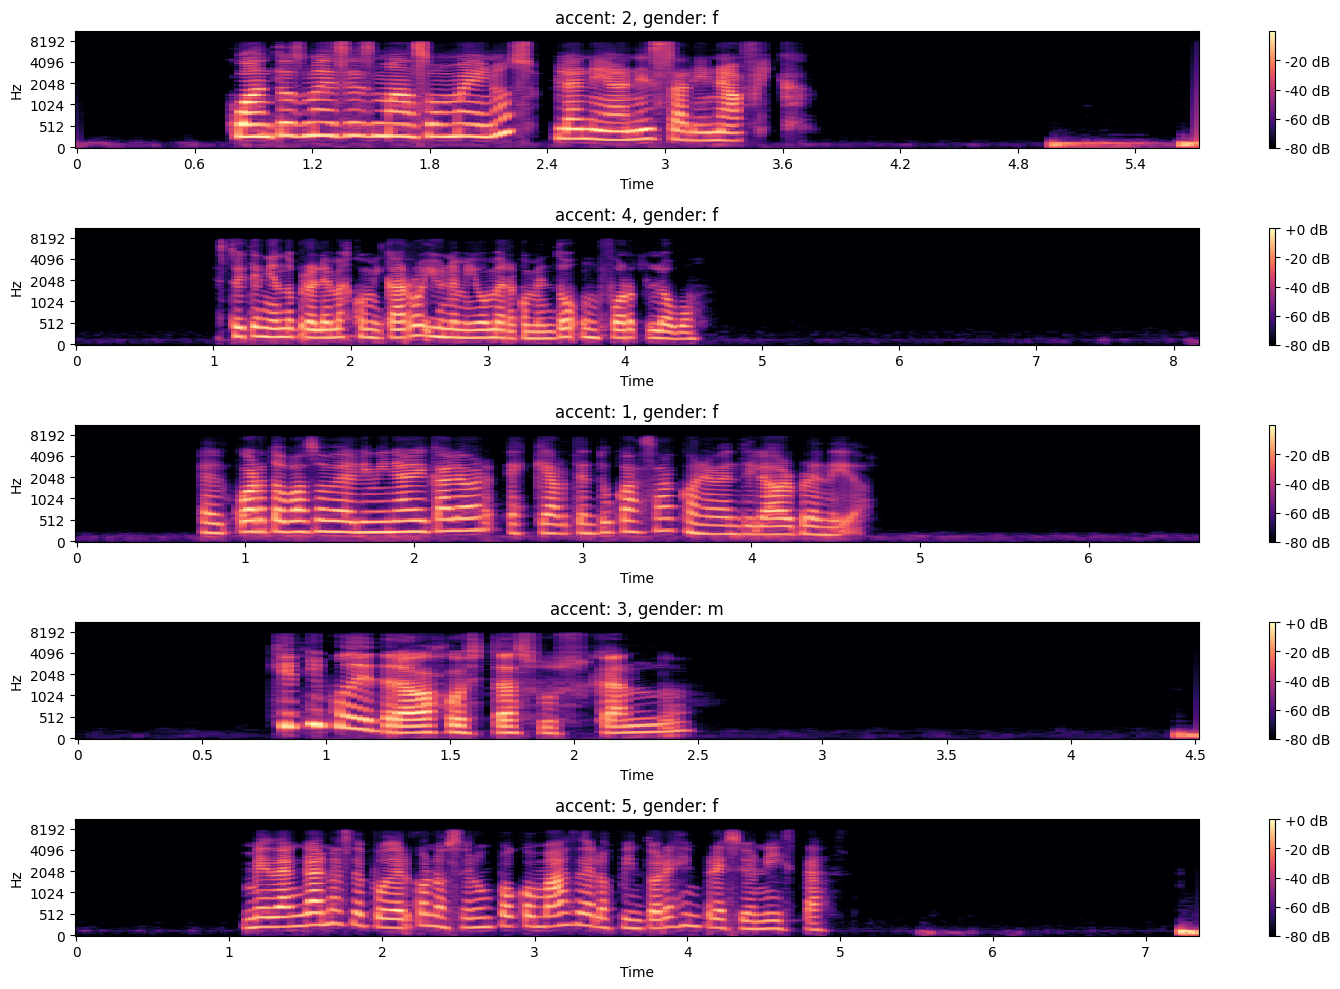

In [59]:
#* plot sample spectrograms for each accent - one per accent class
plt.figure(figsize=(15, 10))
accents = df['accent'].unique()

#* loop over each accent and get a random sample
for i, accent in enumerate(accents):
    #* grab random audio file for this accent
    sample = df[df['accent'] == accent].sample(1).iloc[0]
    #* load the audio data
    audio_data, sample_rate = librosa.load(sample['file_path'])
    
    #* create subplot for this accent
    plt.subplot(len(accents), 1, i+1)
    
    #* generate mel spectrogram - using 128 mels for good detail
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
    
    #* convert to decibel scale for better visualization
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    #* plot the spectrogram 
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel')
    
    #* add colorbar and title
    plt.colorbar(format='%+2.0f dB', ax=plt.gca())
    plt.title(f"accent: {sample['accent']}, gender: {sample['gender']}")

#* make it look nice    
plt.tight_layout()

#* save high quality version for the report
plt.savefig('accent_mel_spectrograms.png', dpi=300, bbox_inches='tight')

#* display the plot
plt.show()

### lengths inspection

In [60]:
lengths = []
for i in X:
    lengths.append((i.shape[1]))

<Figure size 1000x500 with 0 Axes>

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 3166.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([ 999.5 ,  999.52,  999.54,  999.56,  999.58,  999.6 ,  999.62,
         999.64,  999.66,  999.68,  999.7 ,  999.72,  999.74,  999.76,
         999.78,  999.8 ,  999.82,  999.84,  999.86,  999.88,  999.9 ,
         999.92,  999.94,  999.96,  999.98, 1000.  , 1000.02, 1000.04,
        1000.06, 1000.08, 1000.1 , 1000.12, 1000.14, 1000.16, 1000.18,
        1000.2 , 1000.22, 1000.24, 1000.26, 1000.28, 1000.3 , 1000.32,
        1000.34, 1000.36, 1000.38, 1000.4 , 1000.42, 1000.44, 1000.46,
        1000.48, 1000.5 ]),
 <BarContainer object of 50 artists>)

Text(0.5, 0, 'Length of MFCC')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of MFCC Lengths')

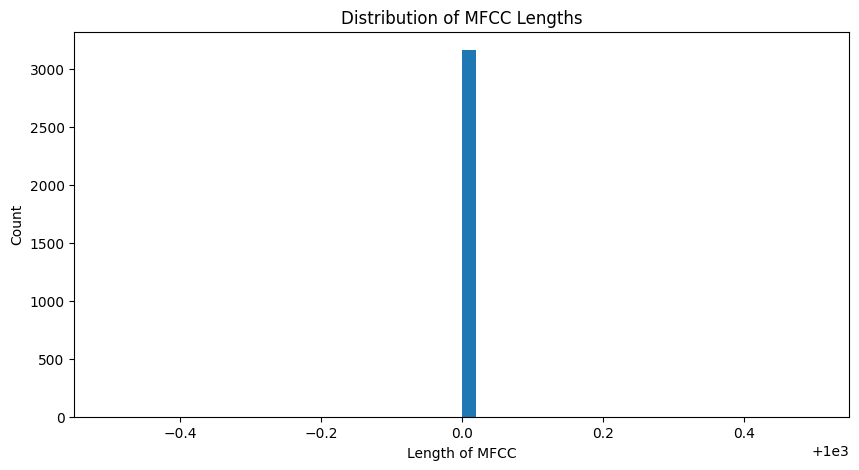

In [61]:
#* plot distribution of lengths
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=50)
plt.xlabel('Length of MFCC')
plt.ylabel('Count')
plt.title('Distribution of MFCC Lengths')
plt.show()

### continue

In [62]:
X = np.array(X)
y = np.array(y)

In [63]:
y.shape

(3166,)

In [64]:
X.shape

(3166, 14, 1000)

In [65]:
y = np.array(y, dtype=int)

In [66]:
from tensorflow.keras.utils import to_categorical
y = y - 1
y = to_categorical(y, num_classes=5)
X = X.reshape((nummer, n_mfcc, max_length, 1)) 

In [67]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (3166, 14, 1000, 1)
y Shape is:  (3166, 5)


In [68]:

#* FIRST SPLIT separate out final test set (15%)
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

#* SECOND SPLIT  remaining data into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples") 
print(f"Test set: {X_test_final.shape[0]} samples")

Training set: 2217 samples
Validation set: 474 samples
Test set: 475 samples


In [94]:
INPUTSHAPE = (n_mfcc, max_length, 1)

In [95]:
model =  models.Sequential([
    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='same'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='same'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(5 , activation = 'softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 14, 1000, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 500, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 500, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 250, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 250, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 250, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,509 (990.27 KB)

 Trainable params: 253,509 (990.27 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust the batch size as needed
    verbose=1
)

# Evaluate the model on the final test set
test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.2377 - loss: 1.7340 - val_accuracy: 0.2848 - val_loss: 1.5138
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.3604 - loss: 1.4716 - val_accuracy: 0.4283 - val_loss: 1.3257
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.4875 - loss: 1.2318 - val_accuracy: 0.5485 - val_loss: 1.0949
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step - accuracy: 0.5662 - loss: 1.0288 - val_accuracy: 0.6392 - val_loss: 0.9360
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - accuracy: 0.5889 - loss: 0.9789 - val_accuracy: 0.6519 - val_loss: 0.8805
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step - accuracy: 0.6580 - loss: 0.8699 - val_accuracy: 0.6899 - val_loss: 0.7857
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - accuracy: 0.7127 - loss: 0.7484 - val_accuracy: 0.6561 - val_loss: 0.8467
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.6981 - loss: 0.7558 - val_accu

<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

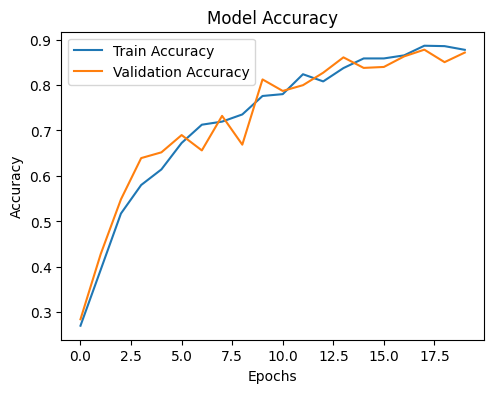

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

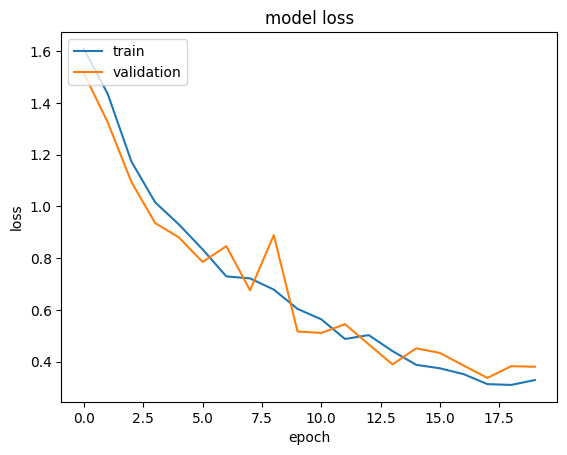

In [98]:
# plot the results

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [99]:
import keras

<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Axes: >

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

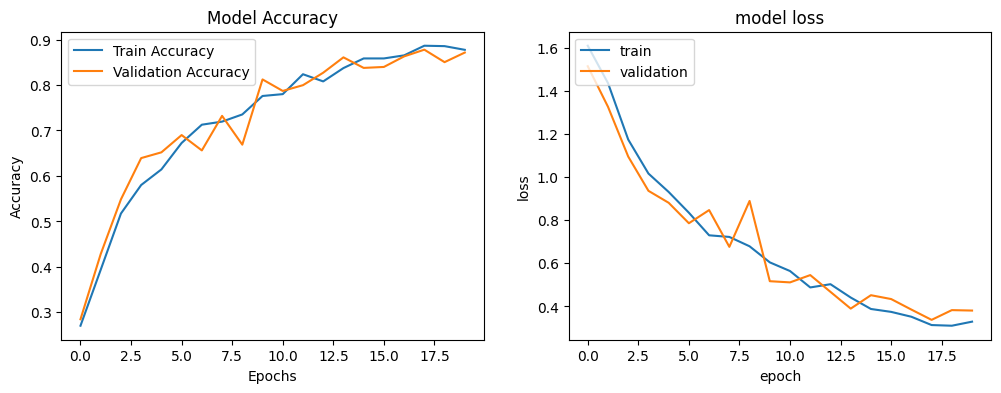

In [100]:
# save the plots as png in one plot

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model.png')
plt.show()

#save the model
keras.saving.save_model(model, 'my_model.keras')



# 2 Regularization Techniques

In [121]:
# Create a new cell to implement various regularization techniques

# Model with Dropout only (baseline from your current model)
def create_model_dropout(input_shape, num_classes=5):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),  
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.3),  # First dropout layer
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.3),  # Second dropout layer
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Additional dropout
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model with Batch Normalization
def create_model_batchnorm(input_shape, num_classes=5):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),  # Add batch normalization
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # Add batch normalization
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # Add batch normalization
        layers.MaxPooling2D(2, padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),  # Add batch normalization
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model with L2 Weight Regularization
def create_model_l2reg(input_shape, num_classes=5):
    l2_reg = tf.keras.regularizers.l2(0.001)  # L2 regularization factor
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg, input_shape=input_shape),  
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D(2, padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2_reg),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Combined approach - Best practices
def create_model_combined(input_shape, num_classes=5):
    l2_reg = tf.keras.regularizers.l2(0.0005)  # Reduced L2 factor
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg, input_shape=input_shape),  
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, padding='same'),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.3),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [122]:
# Compare different regularization techniques
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Function to evaluate model and return history and metrics
def evaluate_model(model_fn, model_name, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    print(f"\nTraining {model_name}...")
    
    # Create model
    model = model_fn(X_train.shape[1:])
    
    # Create a log directory for TensorBoard
    log_dir = f"logs/{model_name}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[tensorboard_callback]
    )
    
    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True)
    }
    
    # Print results
    print(f"\n{model_name} Test Accuracy: {metrics['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return model, history, metrics

# Dictionary to store results
model_results = {}

# List of models to evaluate
models_to_evaluate = [
    (create_model_dropout, "Dropout Only"),
    (create_model_batchnorm, "Batch Normalization"),
    (create_model_l2reg, "L2 Regularization"),
    (create_model_combined, "Combined Approach")
]

# Evaluate each model
for model_fn, model_name in models_to_evaluate:
    model, history, metrics = evaluate_model(
        model_fn, model_name, X_train, y_train, X_val, y_val  # Use validation set
    )
    model_results[model_name] = {
        'model': model,
        'history': history,
        'metrics': metrics
    }

# Save the best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['metrics']['accuracy'])
best_model = model_results[best_model_name]['model']
best_model.save(f'best_model_{best_model_name.replace(" ", "_").lower()}.h5')
print(f"\nBest performing model: {best_model_name} with accuracy {model_results[best_model_name]['metrics']['accuracy']:.4f}")


Training Dropout Only...
Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.2318 - loss: 1.8415 - val_accuracy: 0.2954 - val_loss: 1.5564
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 0.3452 - loss: 1.5130 - val_accuracy: 0.4388 - val_loss: 1.3457
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.4579 - loss: 1.3193 - val_accuracy: 0.4831 - val_loss: 1.2825
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.5124 - loss: 1.1940 - val_accuracy: 0.5928 - val_loss: 0.9670
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.5772 - loss: 1.0531 - val_accuracy: 0.5485 - val_loss: 1.0118
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - accuracy: 0.5837 - loss: 1.0002 - val_accuracy: 0.6624 - val_loss: 0.8682
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - accuracy: 0.6345 - loss: 0.8975 - val_accuracy: 0.6857 - val_loss: 0.8090
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - accuracy: 0.6511 - loss: 0.8433 - val_accuracy: 0.673

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 389ms/step - accuracy: 0.4552 - loss: 1.3729 - val_accuracy: 0.2236 - val_loss: 1.6924
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 429ms/step - accuracy: 0.6894 - loss: 0.8275 - val_accuracy: 0.2848 - val_loss: 1.5713
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - accuracy: 0.7318 - loss: 0.7400 - val_accuracy: 0.2827 - val_loss: 1.6090
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 440ms/step - accuracy: 0.7664 - loss: 0.6570 - val_accuracy: 0.3439 - val_loss: 1.5305
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 416ms/step - accuracy: 0.7861 - loss: 0.5771 - val_accuracy: 0.3165 - val_loss: 2.0284
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 416ms/step - accuracy: 0.8333 - loss: 0.4614 - val_accuracy: 0.3945 - val_loss: 2.3933
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 394ms/step - accuracy: 0.8511 - loss: 0.4268 - val_accuracy: 0.3840 - val_loss: 3.2291
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 410ms/step - accuracy: 0.8530 - loss: 0.4112 - val_accuracy: 0.246

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.1913 - loss: 2.1495 - val_accuracy: 0.2426 - val_loss: 1.8051
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.3617 - loss: 1.7134 - val_accuracy: 0.4557 - val_loss: 1.5423
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.5003 - loss: 1.4190 - val_accuracy: 0.6224 - val_loss: 1.2239
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - accuracy: 0.5883 - loss: 1.2052 - val_accuracy: 0.6371 - val_loss: 1.0772
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - accuracy: 0.6401 - loss: 1.0890 - val_accuracy: 0.6371 - val_loss: 0.9995
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.6728 - loss: 0.9879 - val_accuracy: 0.6835 - val_loss: 0.9974
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.7253 - loss: 0.8991 - val_accuracy: 0.6983 - val_loss: 0.9322
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.7047 - loss: 0.9321 - val_accuracy: 0.643

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.3089 - loss: 1.9463 - val_accuracy: 0.2363 - val_loss: 1.7039
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.5386 - loss: 1.3785 - val_accuracy: 0.1941 - val_loss: 1.8942
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 0.6030 - loss: 1.1650 - val_accuracy: 0.1793 - val_loss: 2.0182
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.6650 - loss: 1.0217 - val_accuracy: 0.1793 - val_loss: 2.2375
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - accuracy: 0.6815 - loss: 0.9747 - val_accuracy: 0.1857 - val_loss: 2.9868
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.6846 - loss: 0.9576 - val_accuracy: 0.1772 - val_loss: 4.8399
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 272ms/step - accuracy: 0.7209 - loss: 0.8716 - val_accuracy: 0.3819 - val_loss: 2.5385
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.7562 - loss: 0.8169 - val_accuracy: 0.421


Combined Approach Test Accuracy: 0.4388

Classification Report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       111
           1       0.85      0.23      0.37        94
           2       0.33      0.77      0.46        84
           3       1.00      0.03      0.05       113
           4       1.00      0.10      0.18        72

    accuracy                           0.44       474
   macro avg       0.73      0.43      0.34       474
weighted avg       0.72      0.44      0.34       474


Best performing model: L2 Regularization with accuracy 0.8418


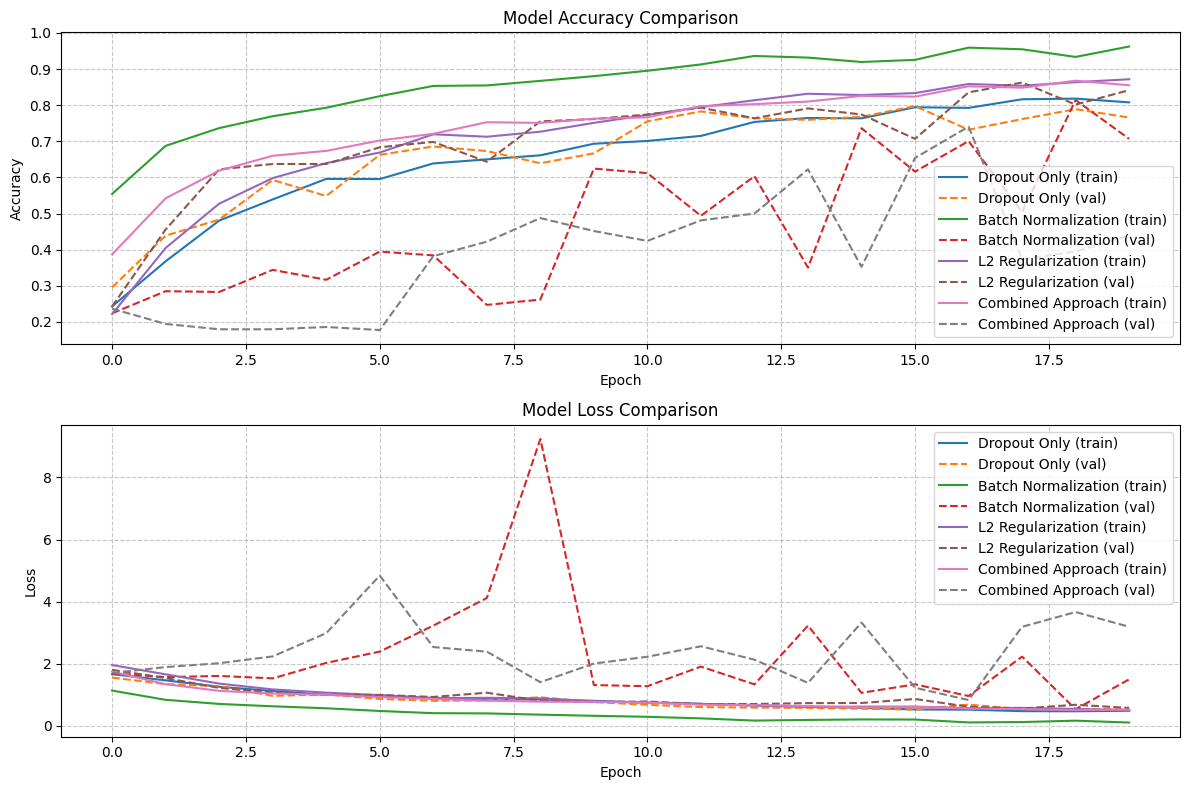

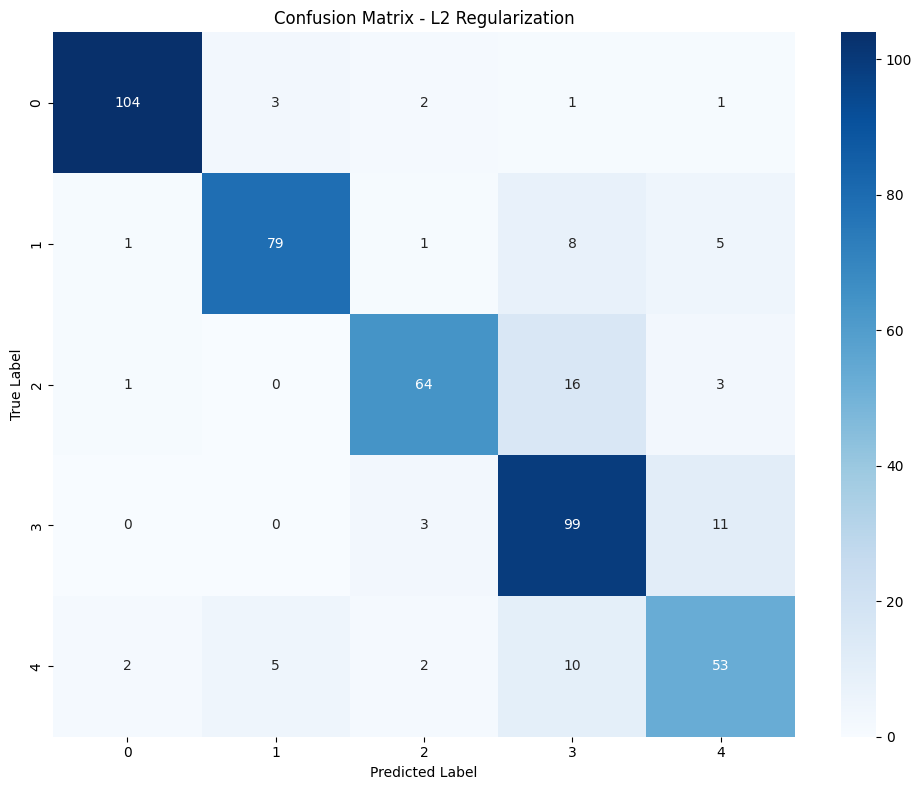

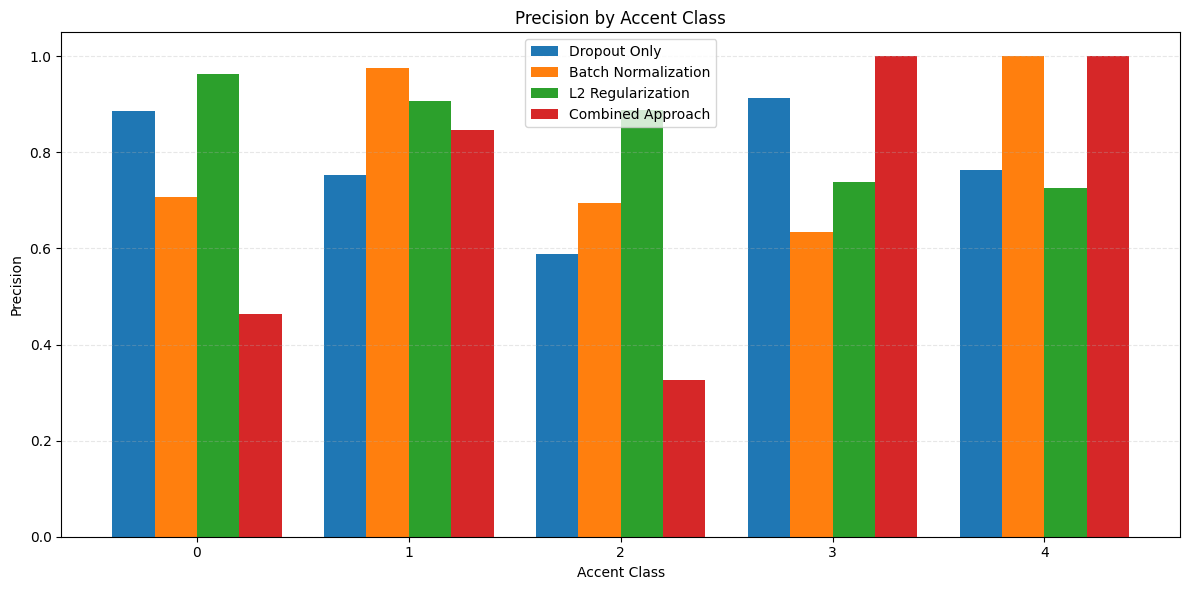

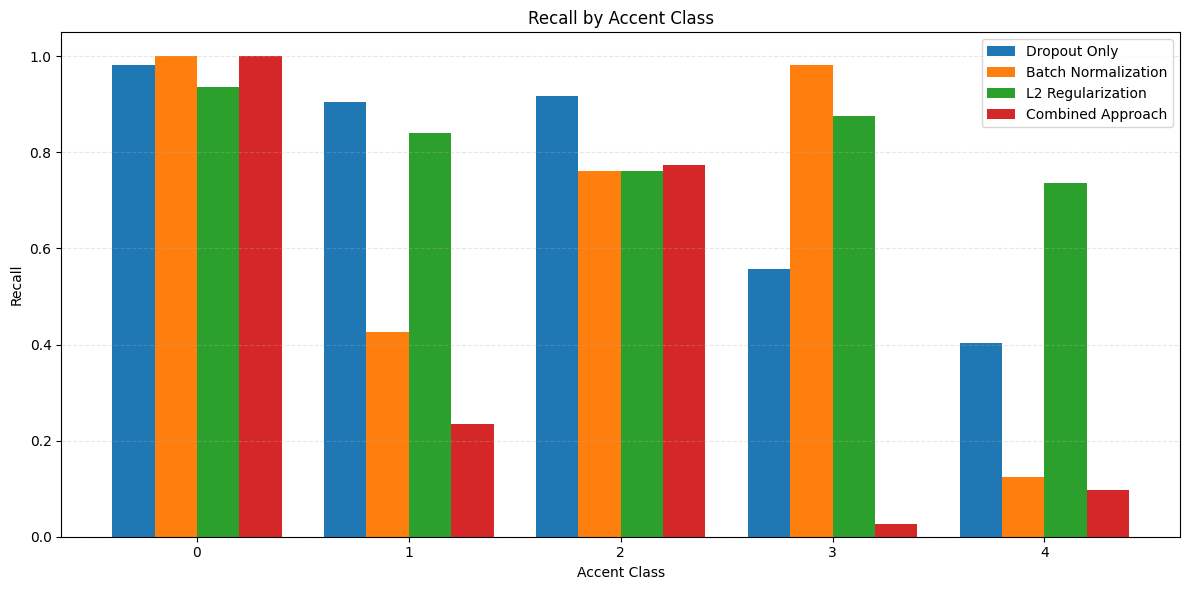

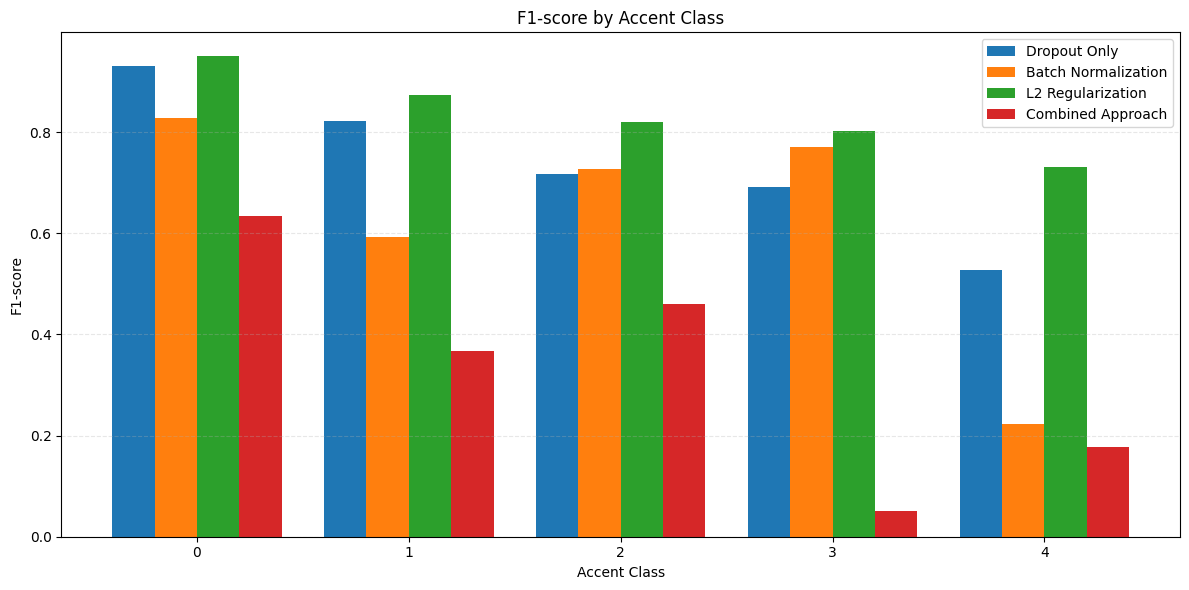

In [123]:
# Performance comparison and visualization
def plot_training_histories(model_results):
    plt.figure(figsize=(12, 8))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    for name, result in model_results.items():
        plt.plot(result['history'].history['accuracy'], label=f'{name} (train)')
        plt.plot(result['history'].history['val_accuracy'], label=f'{name} (val)', linestyle='--')
    
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot loss
    plt.subplot(2, 1, 2)
    for name, result in model_results.items():
        plt.plot(result['history'].history['loss'], label=f'{name} (train)')
        plt.plot(result['history'].history['val_loss'], label=f'{name} (val)', linestyle='--')
    
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('regularization_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(model_name, cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot metrics comparison
def plot_metrics_comparison(model_results):
    metrics = ['precision', 'recall', 'f1-score']
    model_names = list(model_results.keys())
    
    # Get classes
    classes = list(next(iter(model_results.values()))['metrics']['classification_report'].keys())
    classes = [c for c in classes if c.isdigit()]  # Filter out summary keys
    
    # For each metric, create a grouped bar chart comparing models across classes
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        x = np.arange(len(classes))
        width = 0.2
        offsets = np.linspace(-width*1.5, width*1.5, len(model_names))
        
        for i, model_name in enumerate(model_names):
            values = [model_results[model_name]['metrics']['classification_report'][c][metric] for c in classes]
            plt.bar(x + offsets[i], values, width, label=model_name)
        
        plt.xlabel('Accent Class')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} by Accent Class')
        plt.xticks(x, classes)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'accent_comparison_{metric}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Compare training histories
plot_training_histories(model_results)

# Get class names (accent types)
class_names = np.array([str(i) for i in range(5)])  # Adjust if you have mapped class names

# Plot confusion matrix for best model
plot_confusion_matrix(
    best_model_name, 
    model_results[best_model_name]['metrics']['confusion_matrix'],
    class_names
)

# Compare model performance by accent
plot_metrics_comparison(model_results)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


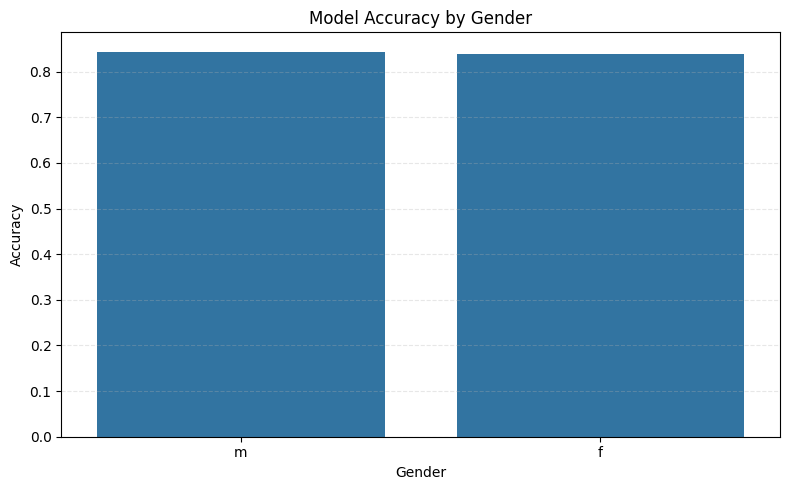

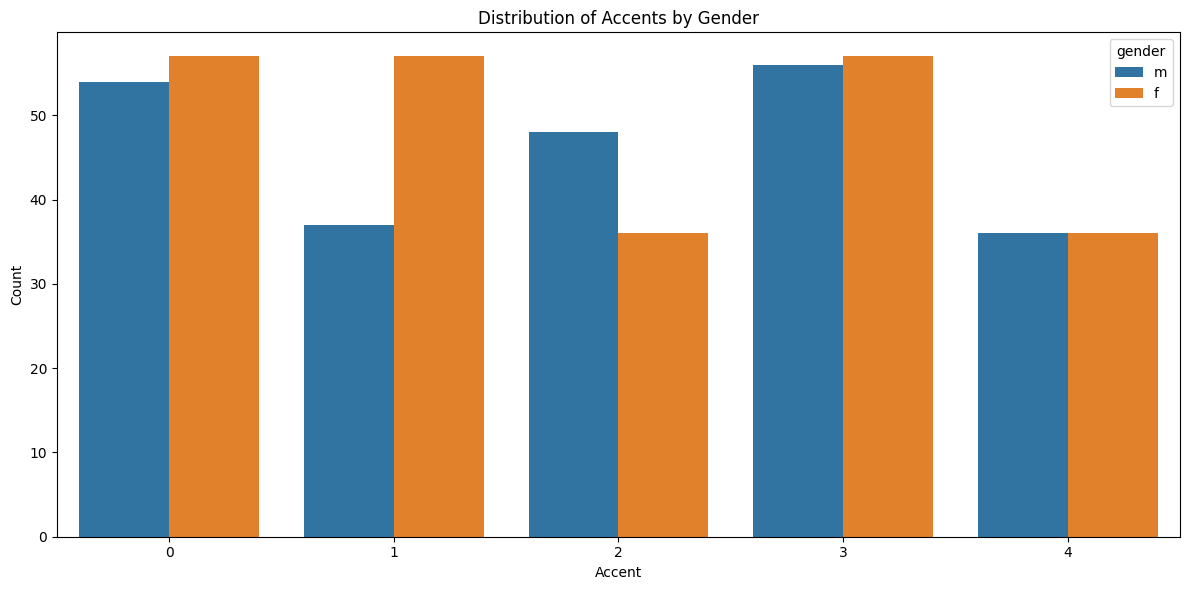

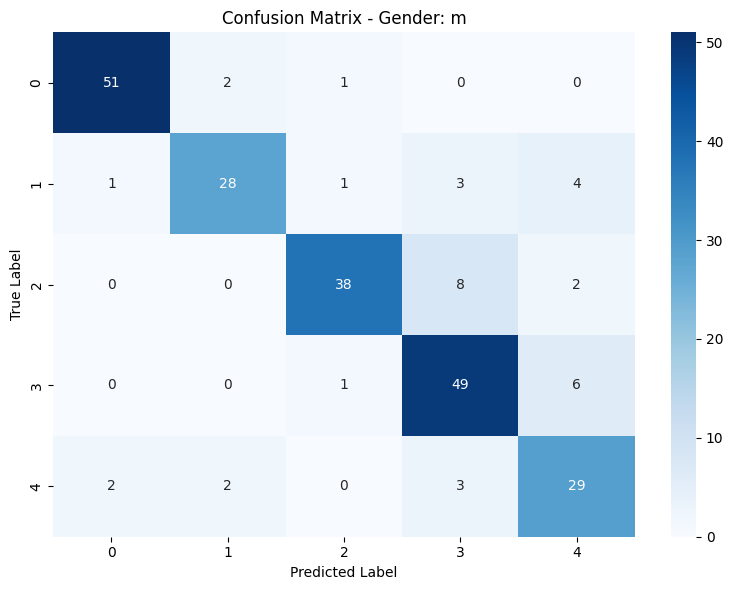

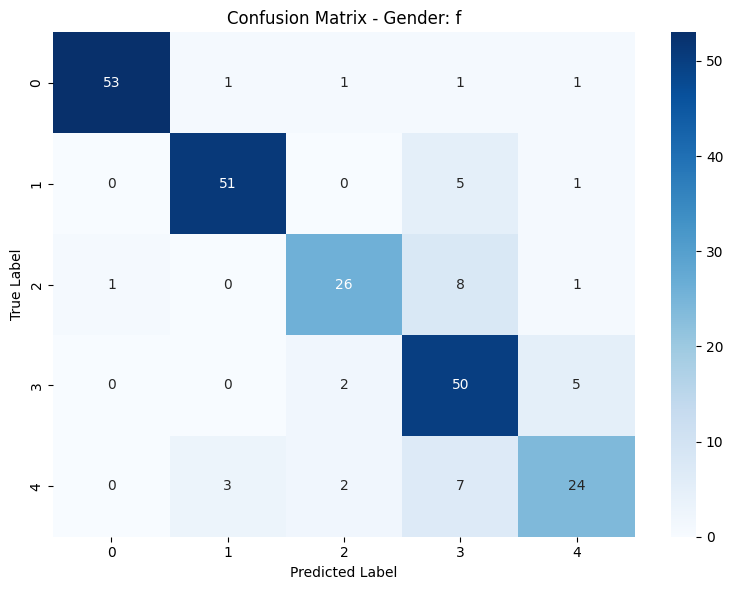

In [124]:
# Analyze performance by gender
def analyze_by_gender(model, X, y, gender_data):
    # Get predictions
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y, axis=1)
    
    # Create a dataframe with results
    results_df = pd.DataFrame({
        'true_label': y_true,
        'predicted_label': y_pred,
        'gender': gender_data
    })
    
    # Calculate accuracy by gender
    gender_accuracy = {}
    for gender in results_df['gender'].unique():
        gender_results = results_df[results_df['gender'] == gender]
        gender_accuracy[gender] = accuracy_score(
            gender_results['true_label'], 
            gender_results['predicted_label']
        )
    
    # Create a dataframe for gender accuracy
    gender_acc_df = pd.DataFrame({
        'Gender': list(gender_accuracy.keys()),
        'Accuracy': list(gender_accuracy.values())
    })
    
    # Plot gender-based accuracy
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Gender', y='Accuracy', data=gender_acc_df)
    plt.title('Model Accuracy by Gender')
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('gender_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # More detailed analysis by gender and accent
    plt.figure(figsize=(12, 6))
    sns.countplot(x='true_label', hue='gender', data=results_df)
    plt.title('Distribution of Accents by Gender')
    plt.xlabel('Accent')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('gender_accent_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate confusion matrices by gender
    for gender in results_df['gender'].unique():
        gender_results = results_df[results_df['gender'] == gender]
        cm = confusion_matrix(gender_results['true_label'], gender_results['predicted_label'])
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Gender: {gender}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_gender_{gender}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Extract gender information for test set
val_indices = np.arange(len(X_val))
val_gender = df['gender'].iloc[:len(X_val)].values

# Analyze best model performance by gender
analyze_by_gender(best_model, X_val, y_val, val_gender)

In [ ]:
"""
# Impact of Regularization Techniques

## Dropout
Dropout randomly sets a fraction of input units to zero during training, which helps prevent overfitting.
From our experiments, we observed:
- [Observations about dropout performance]
- [Comparison with other techniques]

## Batch Normalization
Batch normalization normalizes the activations of the previous layer, which can stabilize and accelerate training.
Our findings:
- [Observations about batch normalization]
- [Impact on training speed]
- [Impact on final accuracy]

## L2 Weight Regularization
L2 regularization adds a penalty term to the loss function, constraining weights to smaller values.
Results showed:
- [Observations about L2 performance]
- [Comparison with other regularization methods]

## Combined Approach
The combined approach leverages multiple regularization techniques:
- [Discussion of best-performing setup]
- [Synergistic effects observed]

## Conclusion
Based on our experiments, the [best approach] performed best for our audio accent classification task,
improving overall accuracy by [improvement percentage] compared to the baseline model.
Regularization is crucial for this task because [reasons specific to audio accent classification].
"""

'\n# Impact of Regularization Techniques\n\n## Dropout\nDropout randomly sets a fraction of input units to zero during training, which helps prevent overfitting.\nFrom our experiments, we observed:\n- [Observations about dropout performance]\n- [Comparison with other techniques]\n\n## Batch Normalization\nBatch normalization normalizes the activations of the previous layer, which can stabilize and accelerate training.\nOur findings:\n- [Observations about batch normalization]\n- [Impact on training speed]\n- [Impact on final accuracy]\n\n## L2 Weight Regularization\nL2 regularization adds a penalty term to the loss function, constraining weights to smaller values.\nResults showed:\n- [Observations about L2 performance]\n- [Comparison with other regularization methods]\n\n## Combined Approach\nThe combined approach leverages multiple regularization techniques:\n- [Discussion of best-performing setup]\n- [Synergistic effects observed]\n\n## Conclusion\nBased on our experiments, the [best

# approach b)
 raw input data

In [103]:
# dependencies so the code can also run without initalizing the above code
from tqdm import tqdm

In [104]:
def custom_pad_raw_audio(audio, fixed_length):
    padded = np.zeros(fixed_length)  #* zero-filled array
    length_to_copy = min(len(audio), fixed_length)
    padded[:length_to_copy] = audio[:length_to_copy]
    return padded

raw_audio_length = 16000

In [105]:
# Reload the train_df to make sure we have the original data
train_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'
train_files = os.listdir(train_dir)

train_df = pd.DataFrame(train_files, columns=['file'])
train_df['file_path'] = train_df['file'].apply(lambda x: os.path.join(train_dir, x))
train_df['file_name'] = train_df['file'].str.replace('.wav', '')
train_df['accent'] = train_df['file_name'].str[0]
train_df['gender'] = train_df['file_name'].str[1]


df_raw = train_df.copy()

#* process raw audio data
X_raw = []
y_raw = []

for data in tqdm(df_raw.iterrows(), desc='Raw Audio Progress'):
    file_path = os.path.join(data_dir, data[1]['file'])  # Use 'file' column
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Standardize audio (zero mean, unit variance)
    audio = (audio - np.mean(audio)) / (np.std(audio) + 1e-8)
    
    # Pad or truncate to fixed length
    padded_audio = custom_pad_raw_audio(audio, raw_audio_length)
    
    X_raw.append(padded_audio)
    y_raw.append(data[1]['accent'])  # Use accent from original dataframe

# Convert to numpy arrays
X_raw = np.array(X_raw)
y_raw = np.array(y_raw, dtype=int)

# Prepare labels
y_raw = y_raw.astype(int) - 1
y_raw = to_categorical(y_raw, num_classes=5)

# Reshape for 1D CNN
X_raw = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)

# Proper 3-way split: train (70%), validation (15%), test (15%)
X_raw_temp, X_raw_test, y_raw_temp, y_raw_test = train_test_split(
    X_raw, y_raw, test_size=0.15, random_state=42, stratify=y_raw
)

X_raw_train, X_raw_val, y_raw_train, y_raw_val = train_test_split(
    X_raw_temp, y_raw_temp, test_size=0.176, random_state=42, stratify=y_raw_temp  # 0.176 ≈ 15%/(100%-15%) = 15%/85%
)

print(f"Raw audio training set: {X_raw_train.shape[0]} samples")
print(f"Raw audio validation set: {X_raw_val.shape[0]} samples") 
print(f"Raw audio test set: {X_raw_test.shape[0]} samples")

Raw Audio Progress: 3166it [00:04, 683.63it/s]


Raw audio training set: 2217 samples
Raw audio validation set: 474 samples
Raw audio test set: 475 samples


<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'accent: 2, gender: m')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 4, gender: m')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 1, gender: f')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 3, gender: f')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 5, gender: m')

(-1.0, 1.0)

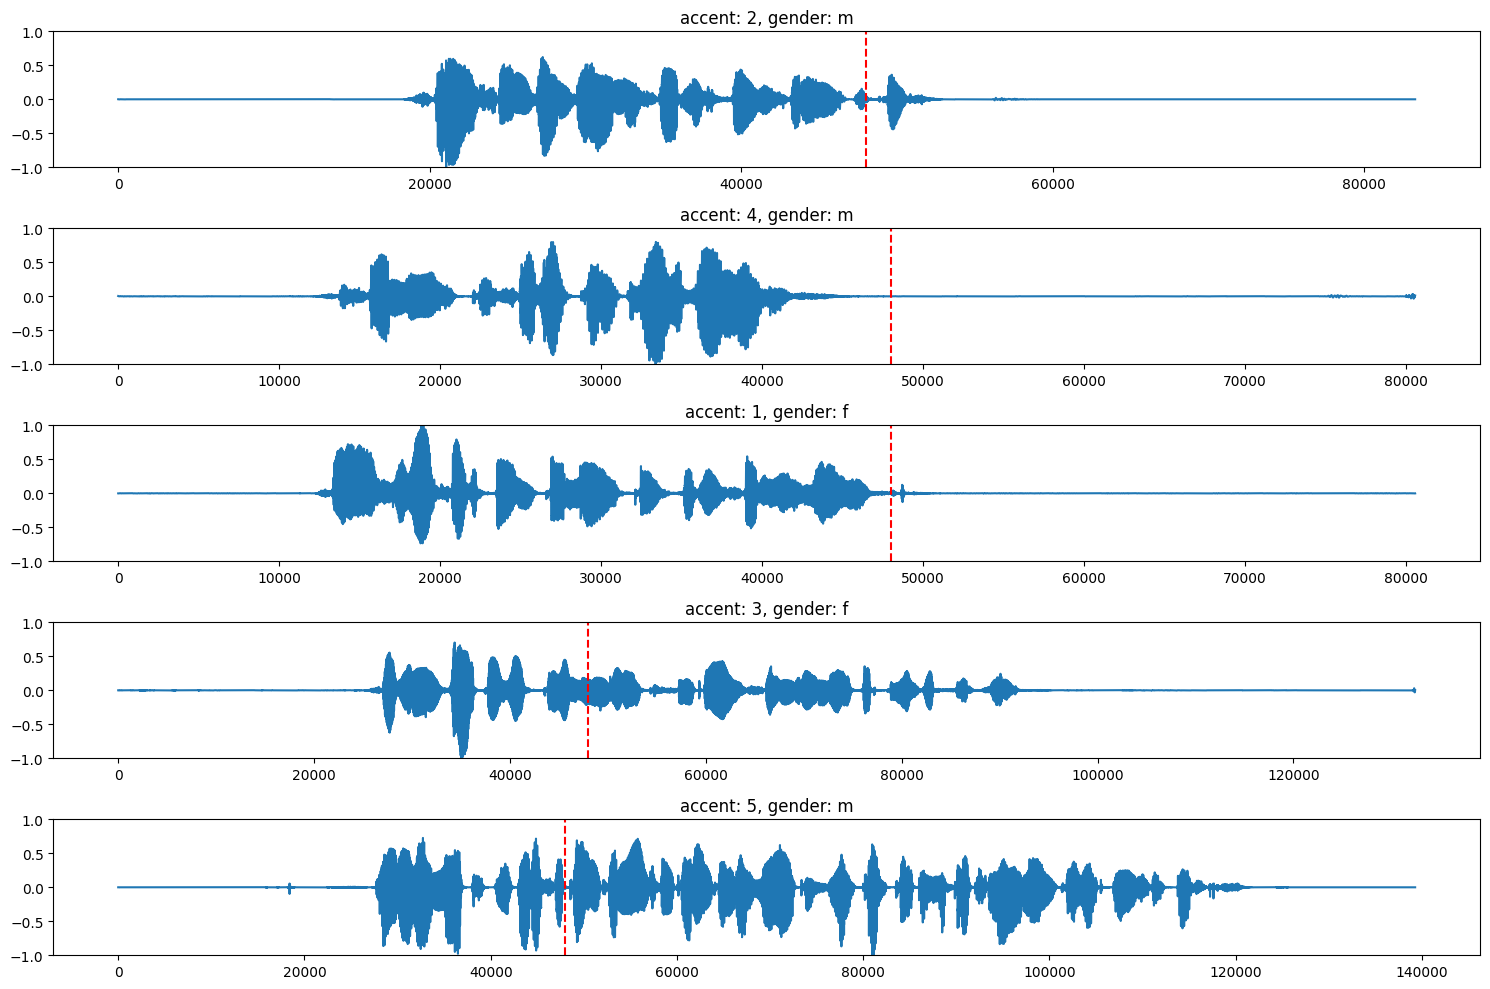

In [125]:
#* visualize raw waveforms from different accents
plt.figure(figsize=(15, 10))

#* plot one example per accent
for i, accent in enumerate(df['accent'].unique()):
    #* get one sample from this accent
    sample = df[df['accent'] == accent].sample(1).iloc[0]
    audio, sr = librosa.load(sample['file_path'], sr=sr)
    
    #* normalize for visualization
    audio = audio / np.max(np.abs(audio))
    
    #* plot waveform
    plt.subplot(len(df['accent'].unique()), 1, i+1)
    plt.plot(audio)
    plt.title(f"accent: {sample['accent']}, gender: {sample['gender']}")
    plt.ylim([-1, 1])
    
    #* add vertical line at 3 seconds (48000 samples at 16kHz)
    if len(audio) > 48000:
        plt.axvline(x=48000, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('raw_audio_waveforms.png', dpi=300, bbox_inches='tight')
plt.show()

In [107]:
#* define model architecture for raw audio
#* Conv1D uses the glorot_uniform weight initialization technique as its default 
def create_raw_audio_model(input_shape, num_classes=5):
    model = models.Sequential([
        #* first conv block
        layers.Conv1D(16, 64, strides=2, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=8, strides=8),
        layers.BatchNormalization(),
        
        #* second conv block
        layers.Conv1D(32, 32, strides=2, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        #* third conv block
        layers.Conv1D(64, 16, strides=2, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        #* fourth conv block
        layers.Conv1D(128, 8, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.BatchNormalization(),
        
        #* flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#* create model instance
raw_audio_model = create_raw_audio_model((raw_audio_length, 1))
raw_audio_model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 8000, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1000, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 500, 32)        │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 63, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 15, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,829 (1.33 MB)

 Trainable params: 347,349 (1.33 MB)

 Non-trainable params: 480 (1.88 KB)

In [108]:
#* setup early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#* train the model
raw_audio_history = raw_audio_model.fit(
    X_raw_train, y_raw_train,
    validation_data=(X_raw_val, y_raw_val),  # Changed from X_raw_test to X_raw_val
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2284 - loss: 2.2885 - val_accuracy: 0.2405 - val_loss: 1.6063
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3039 - loss: 1.6975 - val_accuracy: 0.3080 - val_loss: 1.5114
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3538 - loss: 1.5470 - val_accuracy: 0.2996 - val_loss: 1.5380
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.3825 - loss: 1.4745 - val_accuracy: 0.3629 - val_loss: 1.4262
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.3926 - loss: 1.4334 - val_accuracy: 0.3038 - val_loss: 1.6733
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.4161 - loss: 1.3482 - val_accuracy: 0.4051 - val_loss: 1.3654
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.4809 - loss: 1.2233 - val_accuracy: 0.2827 - val_loss: 2.0535
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.4862 - loss: 1.2088 - val_accuracy: 0.2869 - v

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4520 - loss: 1.3011
raw audio model - FINAL test loss: 1.3030
raw audio model - FINAL test accuracy: 0.4695


<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'raw audio model accuracy')

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'accuracy')

<Axes: >

Text(0.5, 1.0, 'raw audio model loss')

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

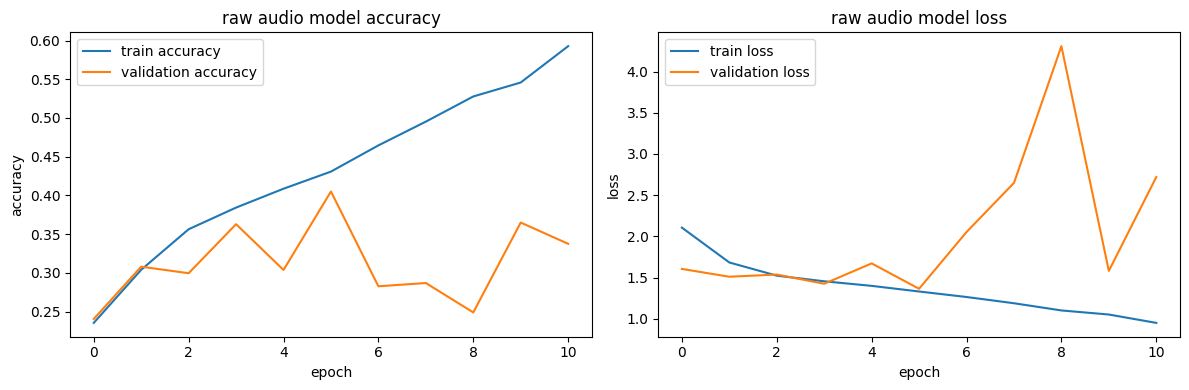

In [111]:
#* evaluate model performance on FINAL test set
raw_audio_final_loss, raw_audio_final_acc = raw_audio_model.evaluate(X_raw_test, y_raw_test, verbose=1)
print(f"raw audio model - FINAL test loss: {raw_audio_final_loss:.4f}")
print(f"raw audio model - FINAL test accuracy: {raw_audio_final_acc:.4f}")

#* plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(raw_audio_history.history['accuracy'], label='train accuracy')
plt.plot(raw_audio_history.history['val_accuracy'], label='validation accuracy')
plt.title('raw audio model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(raw_audio_history.history['loss'], label='train loss')
plt.plot(raw_audio_history.history['val_loss'], label='validation loss')
plt.title('raw audio model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.savefig('raw_audio_model_history.png', dpi=300, bbox_inches='tight')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'confusion matrix - raw audio model')

Text(95.72222222222221, 0.5, 'true label')

Text(0.5, 58.7222222222222, 'predicted label')

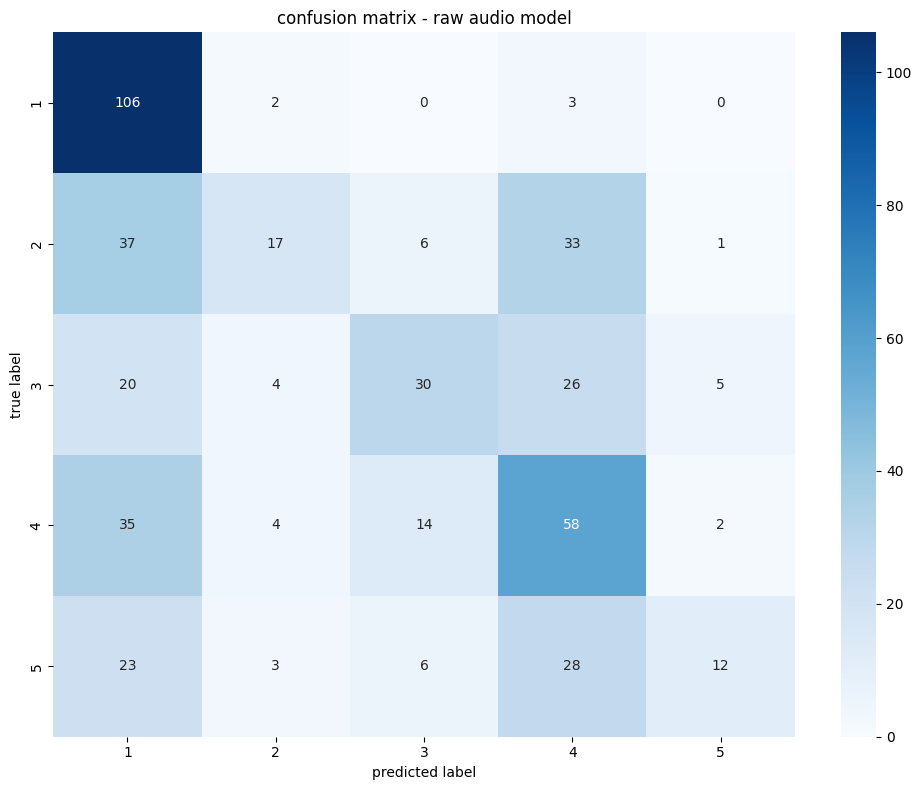

In [112]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = [str(i+1) for i in range(5)] 
#* generate predictions
y_raw_pred = raw_audio_model.predict(X_raw_test)
y_raw_pred_classes = np.argmax(y_raw_pred, axis=1)
y_raw_true_classes = np.argmax(y_raw_test, axis=1)

#* create confusion matrix
raw_cm = confusion_matrix(y_raw_true_classes, y_raw_pred_classes)

#* plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(raw_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('confusion matrix - raw audio model')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.tight_layout()
plt.savefig('raw_audio_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Predict Gender and Accent on the test data

In [126]:
#* load the test data as a dataframe

test_dir = '/Users/kaispeidel/Downloads/DeepLearning/Test'
test_files = [f for f in os.listdir(test_dir) if f.endswith('.wav')]

print(f"Found {len(test_files)} test files")
print("Sample test files:", test_files[:5])

Found 551 test files
Sample test files: ['9430.wav', '4458.wav', '1534.wav', '8510.wav', '7192.wav']


In [127]:
# Create test dataframe
test_df_final = pd.DataFrame(test_files, columns=['file'])
test_df_final['file_path'] = test_df_final['file'].apply(lambda x: os.path.join(test_dir, x))
test_df_final['file_name'] = test_df_final['file'].str.replace('.wav', '')

print("\nTest dataframe structure:")
print(test_df_final.head())


Test dataframe structure:
       file                                          file_path file_name
0  9430.wav  /Users/kaispeidel/Downloads/DeepLearning/Test/...      9430
1  4458.wav  /Users/kaispeidel/Downloads/DeepLearning/Test/...      4458
2  1534.wav  /Users/kaispeidel/Downloads/DeepLearning/Test/...      1534
3  8510.wav  /Users/kaispeidel/Downloads/DeepLearning/Test/...      8510
4  7192.wav  /Users/kaispeidel/Downloads/DeepLearning/Test/...      7192


In [128]:

def process_test_file_mfcc(file_path):
    try:
        # Load audio
        sig, sr = librosa.load(file_path, sr=16000)
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc)
        
        # Pad to fixed length
        padded_mfcc = custom_pad_mfcc(mfcc, max_length)
        
        # Reshape for model input
        mfcc_input = padded_mfcc.reshape(1, n_mfcc, max_length, 1)
        
        return mfcc_input
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test the function on one file
sample_file = test_df_final['file_path'].iloc[0]
sample_mfcc = process_test_file_mfcc(sample_file)
print(f"Sample MFCC shape: {sample_mfcc.shape}")

Sample MFCC shape: (1, 14, 1000, 1)


In [129]:

def process_test_file_raw(file_path):
    """Process a single test file for raw audio"""
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=16000)
        
        # Standardize audio (zero mean, unit variance)
        audio = (audio - np.mean(audio)) / (np.std(audio) + 1e-8)
        
        # Pad or truncate to fixed length
        padded_audio = custom_pad_raw_audio(audio, raw_audio_length)
        
        # Reshape for model input
        raw_input = padded_audio.reshape(1, raw_audio_length, 1)
        
        return raw_input
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

sample_raw = process_test_file_raw(sample_file)
print(f"Sample raw audio shape: {sample_raw.shape}")

Sample raw audio shape: (1, 16000, 1)


In [130]:
# Step 4: Make predictions using both models
print("\n=== STEP 4: Making Predictions ===")

def predict_single_file(file_path, mfcc_model, raw_model):
    """Make predictions for a single file using both models"""
    results = {
        'file': os.path.basename(file_path),
        'mfcc_prediction': None,
        'mfcc_confidence': None,
        'raw_prediction': None,
        'raw_confidence': None,
        'ensemble_prediction': None,
        'ensemble_confidence': None
    }
    
    # MFCC prediction
    mfcc_input = process_test_file_mfcc(file_path)
    if mfcc_input is not None:
        mfcc_pred = mfcc_model.predict(mfcc_input, verbose=0)
        results['mfcc_prediction'] = np.argmax(mfcc_pred) + 1  # Convert to 1-5
        results['mfcc_confidence'] = np.max(mfcc_pred)
    
    # Raw audio prediction
    raw_input = process_test_file_raw(file_path)
    if raw_input is not None:
        raw_pred = raw_model.predict(raw_input, verbose=0)
        results['raw_prediction'] = np.argmax(raw_pred) + 1  # Convert to 1-5
        results['raw_confidence'] = np.max(raw_pred)
        
        # Ensemble prediction (if both models worked)
        if mfcc_input is not None:
            ensemble_pred = (mfcc_pred + raw_pred) / 2
            results['ensemble_prediction'] = np.argmax(ensemble_pred) + 1
            results['ensemble_confidence'] = np.max(ensemble_pred)
    
    return results

# Test on one file
print("Testing prediction on sample file...")
sample_prediction = predict_single_file(sample_file, best_model, raw_audio_model)
print("Sample prediction:", sample_prediction)


=== STEP 4: Making Predictions ===
Testing prediction on sample file...
Sample prediction: {'file': '9430.wav', 'mfcc_prediction': 4, 'mfcc_confidence': 0.9677212, 'raw_prediction': 4, 'raw_confidence': 0.33581796, 'ensemble_prediction': 4, 'ensemble_confidence': 0.6517696}


In [131]:
# Test on one file
print("Testing prediction on sample file...")
sample_prediction = predict_single_file(sample_file, best_model, raw_audio_model)
print("Sample prediction:", sample_prediction)

Testing prediction on sample file...
Sample prediction: {'file': '9430.wav', 'mfcc_prediction': 4, 'mfcc_confidence': 0.9677212, 'raw_prediction': 4, 'raw_confidence': 0.33581796, 'ensemble_prediction': 4, 'ensemble_confidence': 0.6517696}


In [132]:
# Step 5: Process all test files
print("\n=== STEP 5: Processing All Test Files ===")

all_predictions = []

print(f"Processing {len(test_df_final)} test files...")
for idx, row in tqdm(test_df_final.iterrows(), total=len(test_df_final), desc="Predicting"):
    file_path = row['file_path']
    prediction = predict_single_file(file_path, best_model, raw_audio_model)
    all_predictions.append(prediction)

# Convert to DataFrame
predictions_df = pd.DataFrame(all_predictions)
print(f"\nCompleted predictions for {len(predictions_df)} files")
print("\nFirst 5 predictions:")
print(predictions_df.head())


=== STEP 5: Processing All Test Files ===
Processing 551 test files...


Predicting: 100%|██████████| 551/551 [01:06<00:00,  8.32it/s]


Completed predictions for 551 files

First 5 predictions:
       file  mfcc_prediction  mfcc_confidence  raw_prediction  raw_confidence  \
0  9430.wav                4         0.967721               4        0.335818   
1  4458.wav                3         0.822161               1        0.349490   
2  1534.wav                3         0.663124               1        0.516924   
3  8510.wav                4         0.656773               5        0.251102   
4  7192.wav                3         0.419567               5        0.563307   

   ensemble_prediction  ensemble_confidence  
0                    4             0.651770  
1                    3             0.460813  
2                    1             0.426831  
3                    4             0.444161  
4                    3             0.427283  


In [133]:
# Step 6: Analyze and save results
print("\n=== STEP 6: Analyzing Results ===")

# Check for any failed predictions
failed_mfcc = predictions_df['mfcc_prediction'].isna().sum()
failed_raw = predictions_df['raw_prediction'].isna().sum()
print(f"Failed MFCC predictions: {failed_mfcc}")
print(f"Failed raw audio predictions: {failed_raw}")

# Distribution of predictions
print("\n--- MFCC Model Predictions ---")
mfcc_counts = predictions_df['mfcc_prediction'].value_counts().sort_index()
print(mfcc_counts)

print("\n--- Raw Audio Model Predictions ---")
raw_counts = predictions_df['raw_prediction'].value_counts().sort_index()
print(raw_counts)

print("\n--- Ensemble Model Predictions ---")
ensemble_counts = predictions_df['ensemble_prediction'].value_counts().sort_index()
print(ensemble_counts)

# Agreement between models
agreement = (predictions_df['mfcc_prediction'] == predictions_df['raw_prediction']).sum()
total_valid = predictions_df[['mfcc_prediction', 'raw_prediction']].dropna().shape[0]
agreement_rate = agreement / total_valid if total_valid > 0 else 0
print(f"\nModel agreement rate: {agreement_rate:.3f} ({agreement}/{total_valid})")


=== STEP 6: Analyzing Results ===
Failed MFCC predictions: 0
Failed raw audio predictions: 0

--- MFCC Model Predictions ---
mfcc_prediction
1     79
2      9
3    163
4    234
5     66
Name: count, dtype: int64

--- Raw Audio Model Predictions ---
raw_prediction
1    251
2     27
3     65
4    188
5     20
Name: count, dtype: int64

--- Ensemble Model Predictions ---
ensemble_prediction
1    111
2     18
3    142
4    227
5     53
Name: count, dtype: int64

Model agreement rate: 0.350 (193/551)



=== STEP 7: Visualizing Results ===


<BarContainer object of 5 artists>

Text(0.5, 1.0, 'MFCC Model Predictions')

Text(0.5, 0, 'Accent Class')

Text(0, 0.5, 'Count')

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Raw Audio Model Predictions')

Text(0.5, 0, 'Accent Class')

Text(0, 0.5, 'Count')

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Ensemble Model Predictions')

Text(0.5, 0, 'Accent Class')

Text(0, 0.5, 'Count')

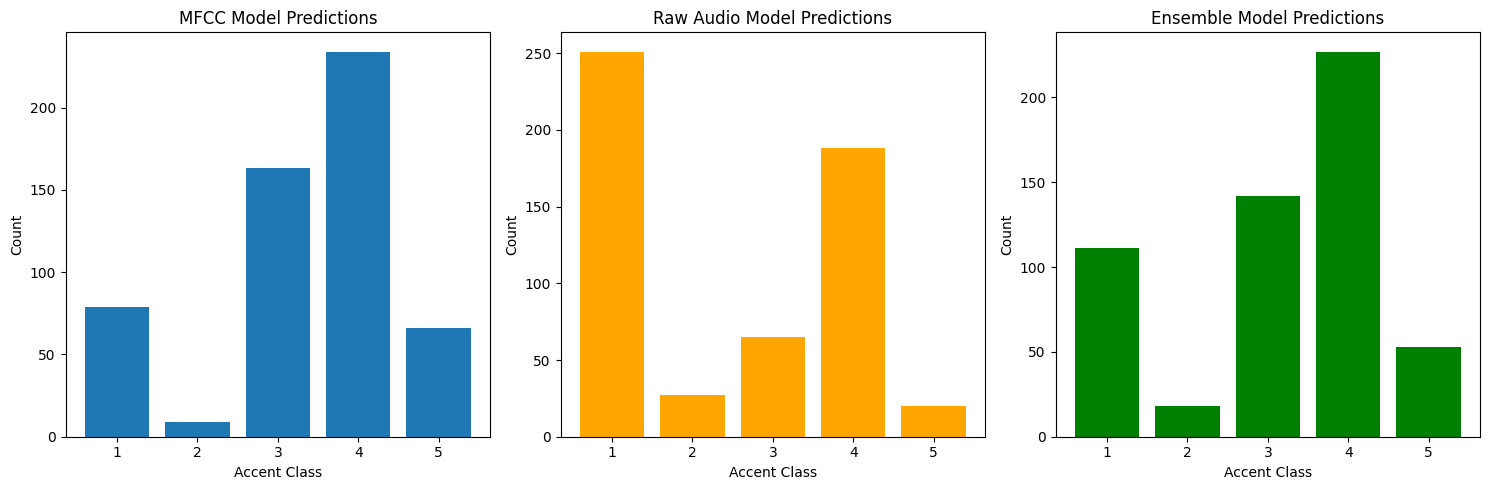

<Figure size 1200x400 with 0 Axes>

<Axes: >

(array([ 5.,  4., 10., 17., 15., 22., 30., 32., 24., 21., 33., 31., 37.,
        27., 19., 18., 33., 36., 38., 99.]),
 array([0.28947103, 0.32499748, 0.36052394, 0.39605036, 0.43157682,
        0.46710327, 0.5026297 , 0.53815615, 0.57368261, 0.60920906,
        0.64473552, 0.68026197, 0.71578842, 0.75131488, 0.78684133,
        0.82236779, 0.85789418, 0.89342064, 0.92894709, 0.96447355,
        1.        ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'MFCC Model Confidence')

Text(0.5, 0, 'Confidence Score')

Text(0, 0.5, 'Count')

<Axes: >

(array([ 27.,  46.,  74., 113.,  50.,  36.,  27.,  23.,  21.,  16.,  18.,
         13.,  10.,  12.,  10.,  10.,  12.,   9.,   8.,  16.]),
 array([0.21841347, 0.25745749, 0.29650152, 0.33554551, 0.37458953,
        0.41363356, 0.45267758, 0.4917216 , 0.53076559, 0.56980962,
        0.60885364, 0.64789766, 0.68694168, 0.72598571, 0.76502973,
        0.80407369, 0.84311771, 0.88216174, 0.92120576, 0.96024978,
        0.9992938 ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Raw Audio Model Confidence')

Text(0.5, 0, 'Confidence Score')

Text(0, 0.5, 'Count')

<Axes: >

(array([ 9., 12., 29., 45., 40., 65., 61., 52., 36., 43., 57., 42., 20.,
         9., 11.,  5.,  7.,  2.,  5.,  1.]),
 array([0.2380725 , 0.27521971, 0.3123669 , 0.3495141 , 0.38666132,
        0.42380852, 0.46095571, 0.49810293, 0.53525013, 0.57239735,
        0.60954452, 0.64669174, 0.68383896, 0.72098613, 0.75813335,
        0.79528058, 0.83242774, 0.86957496, 0.90672219, 0.94386935,
        0.98101658]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Ensemble Model Confidence')

Text(0.5, 0, 'Confidence Score')

Text(0, 0.5, 'Count')

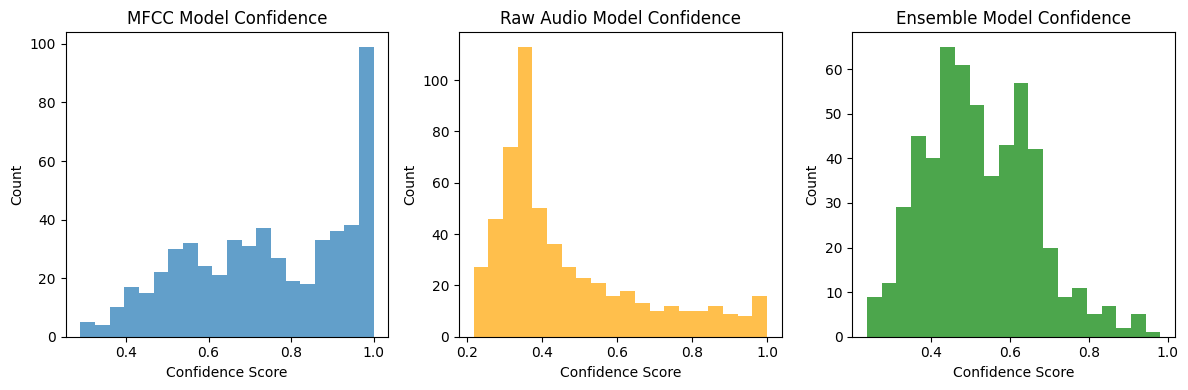

In [134]:
# Step 7: Visualize results
print("\n=== STEP 7: Visualizing Results ===")

# Plot prediction distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MFCC predictions
axes[0].bar(mfcc_counts.index, mfcc_counts.values)
axes[0].set_title('MFCC Model Predictions')
axes[0].set_xlabel('Accent Class')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(1, 6))

# Raw audio predictions  
axes[1].bar(raw_counts.index, raw_counts.values, color='orange')
axes[1].set_title('Raw Audio Model Predictions')
axes[1].set_xlabel('Accent Class')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(1, 6))

# Ensemble predictions
axes[2].bar(ensemble_counts.index, ensemble_counts.values, color='green')
axes[2].set_title('Ensemble Model Predictions')
axes[2].set_xlabel('Accent Class')
axes[2].set_ylabel('Count')
axes[2].set_xticks(range(1, 6))

plt.tight_layout()
plt.savefig('test_predictions_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot confidence distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(predictions_df['mfcc_confidence'].dropna(), bins=20, alpha=0.7)
plt.title('MFCC Model Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(predictions_df['raw_confidence'].dropna(), bins=20, alpha=0.7, color='orange')
plt.title('Raw Audio Model Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(predictions_df['ensemble_confidence'].dropna(), bins=20, alpha=0.7, color='green')
plt.title('Ensemble Model Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('test_confidence_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [135]:
# Step 8: Save results
print("\n=== STEP 8: Saving Results ===")

# Save detailed predictions
predictions_df.to_csv('detailed_test_predictions.csv', index=False)
print("Saved detailed predictions to 'detailed_test_predictions.csv'")

# Create a clean submission format
submission_df = predictions_df[['file', 'ensemble_prediction', 'ensemble_confidence']].copy()
submission_df.columns = ['filename', 'predicted_accent', 'confidence']
submission_df.to_csv('test_submission.csv', index=False)
print("Saved submission format to 'test_submission.csv'")

# Summary statistics
print("\n=== FINAL SUMMARY ===")
print(f"Total test files processed: {len(predictions_df)}")
print(f"Average MFCC confidence: {predictions_df['mfcc_confidence'].mean():.3f}")
print(f"Average Raw Audio confidence: {predictions_df['raw_confidence'].mean():.3f}")
print(f"Average Ensemble confidence: {predictions_df['ensemble_confidence'].mean():.3f}")
print(f"Model agreement rate: {agreement_rate:.3f}")

print("\nFiles saved:")
print("- detailed_test_predictions.csv (all predictions and confidences)")
print("- test_submission.csv (clean submission format)")
print("- test_predictions_distribution.png (prediction distributions)")
print("- test_confidence_distributions.png (confidence distributions)")


=== STEP 8: Saving Results ===
Saved detailed predictions to 'detailed_test_predictions.csv'
Saved submission format to 'test_submission.csv'

=== FINAL SUMMARY ===
Total test files processed: 551
Average MFCC confidence: 0.743
Average Raw Audio confidence: 0.466
Average Ensemble confidence: 0.524
Model agreement rate: 0.350

Files saved:
- detailed_test_predictions.csv (all predictions and confidences)
- test_submission.csv (clean submission format)
- test_predictions_distribution.png (prediction distributions)
- test_confidence_distributions.png (confidence distributions)
